<a href="https://colab.research.google.com/github/kutaydemiralay/Trajectory-optimization-using-LQR-and-MPC/blob/main/Trajectory_optimization_using_LQR_and_MPC_KutayDemiralay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Trajectory optimization of a free flying robot using Linear Quadratic Regulator (LQR) and Model Predictive Control (MPC)**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

Trajectory and Control Sequence obtained with LQR method without disturbance

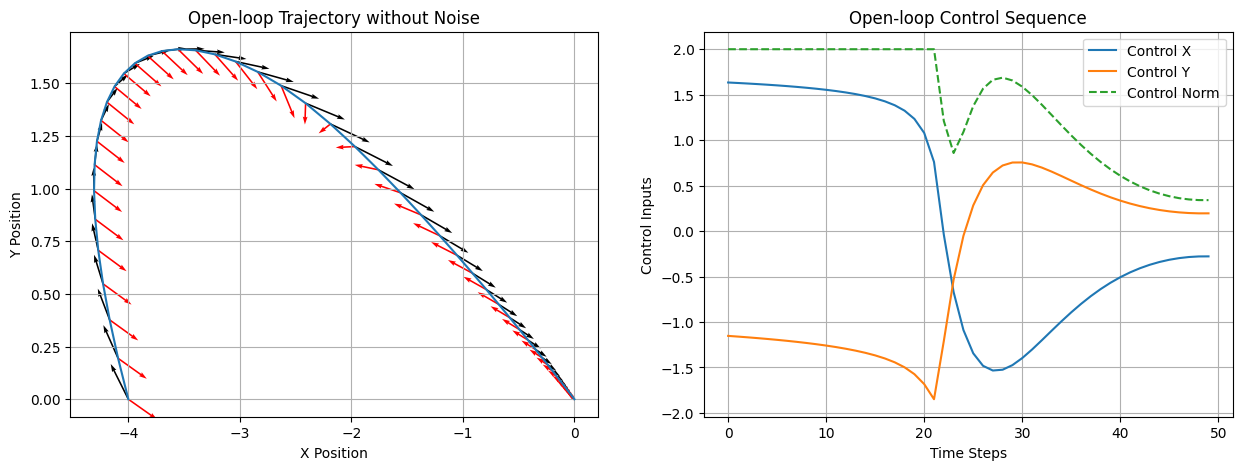

In [6]:
# Time step and dynamics matrices
time_step = 0.1
A = np.array([[1., 0., time_step, 0.],
              [0., 1., 0., time_step],
              [0., 0., 1., 0.],
              [0., 0., 0., 1.]])

B = np.array([[0.5 * time_step**2, 0.],
              [0., 0.5 * time_step**2],
              [time_step, 0.],
              [0., time_step]])

# Total number of time steps and dimensions
total_steps = 50
state_dim = 4
control_dim = 2

# Control optimization variable
control_vars = cp.Variable((total_steps, control_dim))

# Cost matrices
state_cost = np.diag([1., 1., 1., 1.]) * 3
terminal_cost = np.eye(state_dim) * 5.0
control_cost = np.diag([1., 1.]) * 1

# Initial and goal states
target_state = np.zeros(state_dim)
initial_state = np.array([-4, 0., -1., 2.])
current_state = initial_state

# Maximum control input and discount factor
control_limit = 2.
discount_factor = 1.1

# Defining objective and constraints
objective = 0
constraints = []

# Constructing the optimization problem
for t in range(total_steps):
    objective += discount_factor**t * (cp.quad_form(current_state, state_cost) + cp.quad_form(control_vars[t], control_cost))
    next_state = A @ current_state + B @ control_vars[t]
    constraints += [cp.norm(control_vars[t], 2) <= control_limit]
    current_state = next_state

objective += cp.quad_form(current_state - target_state, terminal_cost)
constraints += [current_state == target_state]

# Solving the optimization problem
problem = cp.Problem(cp.Minimize(objective), constraints)
problem.solve()

# Extracting the optimal control sequence
optimal_controls = control_vars.value

# Simulating the system without noise
current_state = initial_state
state_trajectory = [initial_state]

for t in range(total_steps):
    control_input = optimal_controls[t]
    current_state = A @ current_state + B @ control_input
    state_trajectory.append(current_state)

# Converting to arrays for plotting
state_trajectory = np.stack(state_trajectory)

# Plotting the results
plt.figure(figsize=(15, 5))

# Plotting state trajectory
plt.subplot(1, 2, 1)
plt.plot(state_trajectory[:, 0], state_trajectory[:, 1])
plt.quiver(state_trajectory[:, 0], state_trajectory[:, 1], state_trajectory[:, 2], state_trajectory[:, 3], scale=30, width=.003)  # velocity vectors
plt.quiver(state_trajectory[:-1, 0], state_trajectory[:-1, 1], optimal_controls[:, 0], optimal_controls[:, 1], scale=30, width=.003, color='red')  # acceleration vectors
plt.title("Open-loop Trajectory without Noise")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.grid()

# Plotting control sequence
plt.subplot(1, 2, 2)
plt.plot(optimal_controls)
plt.plot(np.linalg.norm(optimal_controls, 2, axis=1), '--')
plt.title("Open-loop Control Sequence")
plt.xlabel("Time Steps")
plt.ylabel("Control Inputs")
plt.legend(["Control X", "Control Y", "Control Norm"])
plt.grid()

plt.show()


Trajectory and Control Sequence obtained with LQR method with disturbance

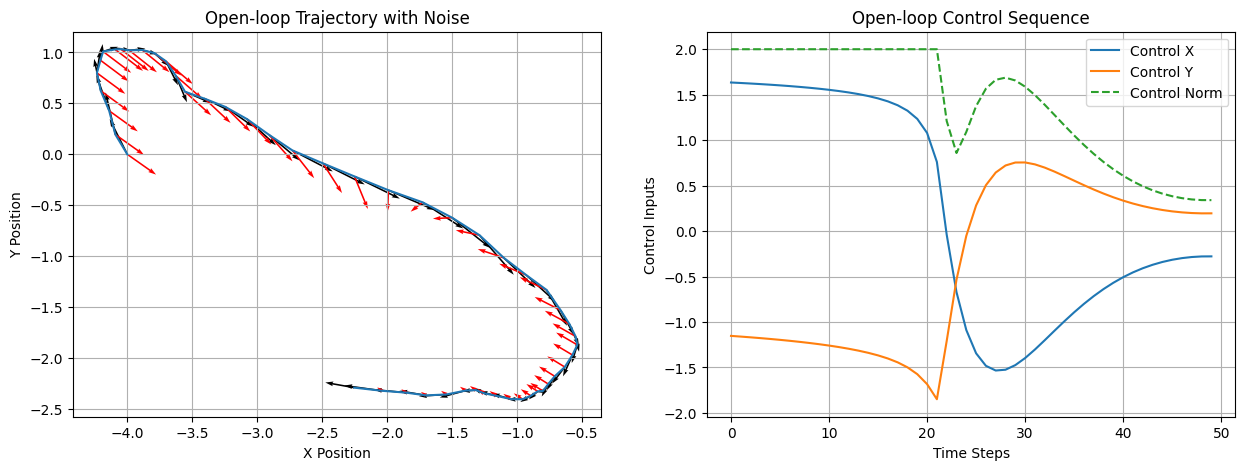

In [5]:
# Time step and dynamics matrices
time_step = 0.1
A = np.array([[1., 0., time_step, 0.],
              [0., 1., 0., time_step],
              [0., 0., 1., 0.],
              [0., 0., 0., 1.]])

B = np.array([[0.5 * time_step**2, 0.],
              [0., 0.5 * time_step**2],
              [time_step, 0.],
              [0., time_step]])

# Total number of time steps and dimensions
total_steps = 50
state_dim = 4
control_dim = 2

# Control optimization variable
control_vars = cp.Variable((total_steps, control_dim))

# Cost matrices
state_cost = np.diag([1., 1., 1., 1.]) * 3
terminal_cost = np.eye(state_dim) * 5.0
control_cost = np.diag([1., 1.]) * 1

# Initial and goal states
target_state = np.zeros(state_dim)
initial_state = np.array([-4, 0., -1., 2.])
current_state = initial_state

# Maximum control input and discount factor
control_limit = 2.
discount_factor = 1.1

# Noise covariance matrix
noise_cov = np.diag([0., 0., 0.1, 0.1])

# Defining objective and constraints
objective = 0
constraints = []

# Constructing the optimization problem
for t in range(total_steps):
    objective += discount_factor**t * (cp.quad_form(current_state, state_cost) + cp.quad_form(control_vars[t], control_cost))
    next_state = A @ current_state + B @ control_vars[t]
    constraints += [cp.norm(control_vars[t], 2) <= control_limit]
    current_state = next_state

objective += cp.quad_form(current_state - target_state, terminal_cost)
constraints += [current_state == target_state]

# Solving the optimization problem
problem = cp.Problem(cp.Minimize(objective), constraints)
problem.solve()

# Extracting the optimal control sequence
optimal_controls = control_vars.value

# Simulating the system with noise
current_state = initial_state
state_trajectory = [initial_state]

for t in range(total_steps):
    control_input = optimal_controls[t]
    current_state = A @ current_state + B @ control_input + np.random.multivariate_normal(np.zeros(state_dim), noise_cov)
    state_trajectory.append(current_state)

# Converting to arrays for plotting
state_trajectory = np.stack(state_trajectory)

# Plotting the results
plt.figure(figsize=(15, 5))

# Plotting state trajectory
plt.subplot(1, 2, 1)
plt.plot(state_trajectory[:, 0], state_trajectory[:, 1])
plt.quiver(state_trajectory[:, 0], state_trajectory[:, 1], state_trajectory[:, 2], state_trajectory[:, 3], scale=30, width=.003)  # velocity vectors
plt.quiver(state_trajectory[:-1, 0], state_trajectory[:-1, 1], optimal_controls[:, 0], optimal_controls[:, 1], scale=30, width=.003, color='red')  # acceleration vectors
plt.title("Open-loop Trajectory with Noise")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.grid()

# Plotting control sequence
plt.subplot(1, 2, 2)
plt.plot(optimal_controls)
plt.plot(np.linalg.norm(optimal_controls, 2, axis=1), '--')
plt.title("Open-loop Control Sequence")
plt.xlabel("Time Steps")
plt.ylabel("Control Inputs")
plt.legend(["Control X", "Control Y", "Control Norm"])
plt.grid()

plt.show()


Trajectory and Control Sequence obtained with MPC method with disturbance

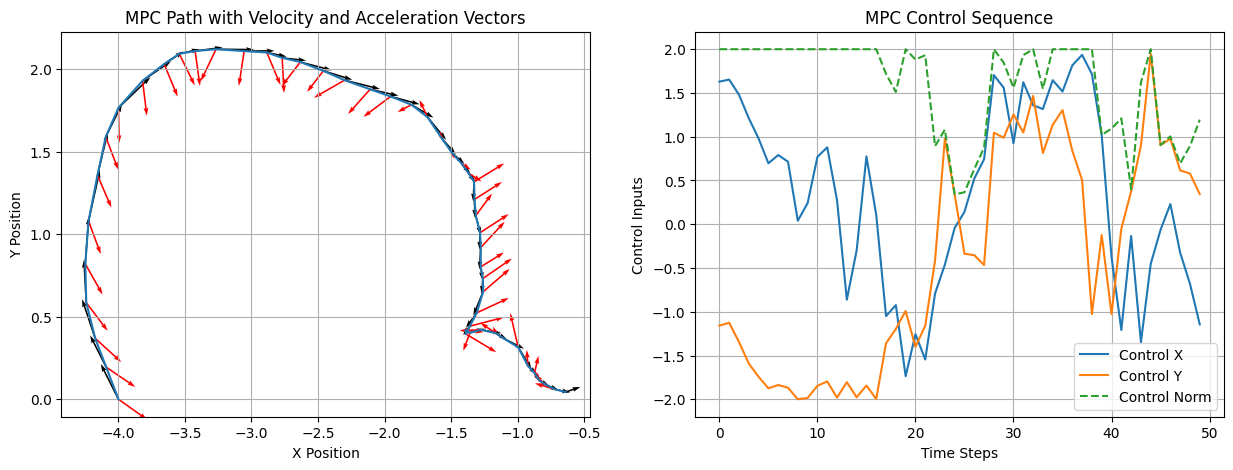

In [1]:
# Parameters
time_step = 0.1
horizon_length = 10
total_time_steps = 50  # total number of time steps
state_dim = 4   # dimension of the state vector
control_dim = 2   # dimension of the control input
control_max = 2.
discount_factor = 1.1

# Dynamics matrices
A = np.array([[1., 0., time_step, 0.],
              [0., 1., 0., time_step],
              [0., 0., 1., 0.],
              [0., 0., 0., 1.]])

B = np.array([[0.5 * time_step**2, 0.],
              [0., 0.5 * time_step**2],
              [time_step, 0.],
              [0., time_step]])

# Cost matrices
Q = np.diag([1., 1., 1., 1.]) * 3
Q_terminal = np.eye(state_dim) * 5.0
R = np.diag([1., 1.]) * 1

# Initial and goal states
goal_state = np.zeros(state_dim)
initial_state = np.array([-4, 0., -1., 2.])
current_state = initial_state

# Noise covariance matrix
noise_covariance = np.diag([0., 0., 0.1, 0.1])

# Storage for states and controls
state_history = [initial_state]
control_history = []

# MPC for loop
for step in range(total_time_steps):
    # Define new variables for the MPC problem
    control_vars = cp.Variable((horizon_length, control_dim))
    state_vars = cp.Variable((horizon_length + 1, state_dim))

    # Initial state constraint
    constraints = [state_vars[0] == current_state]

    # Objective function
    objective = 0
    for t in range(horizon_length):
        objective += discount_factor**t * (cp.quad_form(state_vars[t], Q) + cp.quad_form(control_vars[t], R))
        constraints += [state_vars[t + 1] == A @ state_vars[t] + B @ control_vars[t]]
        constraints += [cp.norm(control_vars[t], 2) <= control_max]

    # Heuristic cost-to-go term
    objective += cp.quad_form(state_vars[horizon_length] - goal_state, Q_terminal)

    # Solving  MPC problem
    problem = cp.Problem(cp.Minimize(objective), constraints)
    problem.solve()

    # Applying first control action
    control_action = control_vars.value[0]
    current_state = A @ current_state + B @ control_action + np.random.multivariate_normal(np.zeros(state_dim), noise_covariance)

    # Storing the results
    state_history.append(current_state)
    control_history.append(control_action)

# Converting to arrays for plotting
state_history = np.stack(state_history)
control_history = np.array(control_history)

# Plotting the results
plt.figure(figsize=(15, 5))

# Plotting state trajectory
plt.subplot(1, 2, 1)
plt.plot(state_history[:, 0], state_history[:, 1])
plt.quiver(state_history[:, 0], state_history[:, 1], state_history[:, 2], state_history[:, 3], scale=30, width=.003)  # velocity vectors
plt.quiver(state_history[:-1, 0], state_history[:-1, 1], control_history[:, 0], control_history[:, 1], scale=30, width=.003, color='red')  # acceleration vectors
plt.title("MPC Path with Velocity and Acceleration Vectors")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.grid()

# Plotting control sequence
plt.subplot(1, 2, 2)
plt.plot(control_history)
plt.plot(np.linalg.norm(control_history, 2, axis=1), '--')
plt.title("MPC Control Sequence")
plt.xlabel("Time Steps")
plt.ylabel("Control Inputs")
plt.legend(["Control X", "Control Y", "Control Norm"])
plt.grid()

plt.show()
